In [1]:
# Disabling any minor warmings and logs
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing necessary libraries
import h5py
import numpy as np
from numpy import concatenate

import pandas as pd
from pandas import read_csv, concat, DataFrame

from matplotlib import pyplot
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.models import Sequential 
from keras.layers import Dense, Dropout, GRU

Using TensorFlow backend.


In [3]:
# Importing the dataset along with some changes
data = read_csv("Dataset/household_power_consumption.csv",
                   parse_dates={'dt' : ['Date', 'Time']},
                   infer_datetime_format=True, 
                   index_col= 0,
                   na_values=['nan', '?'])

In [4]:
# Replacing the '?' median of the data
median_value = data.median()
data = data.fillna(median_value)

# Ensuring all dataset is in float
values = data.values
values = values.astype('float32')

In [5]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)

In [6]:
# Creating a timeseries function to convert the timeseries dataset
def timeseries_data(data, lookback=1, predicted_col=1):
    temp=data.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    
    predicted_value=data.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predicted"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    return final_df

In [7]:
# Reframing the dataset
reframed_df= timeseries_data(scaled, 1,0)
reframed_df.fillna(0, inplace=True)
reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)','var1(t)']

In [8]:
# Spliting the dataset into train and test sets
values = reframed_df.values
train_ = values[:, :-1]
labels = values[:, -1]
train_X, test_X, train_y, test_y = train_test_split(train_, labels, test_size=0.27, random_state=0)

In [9]:
# Reshaping input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [10]:
batch_size = 100
epochs = 15

# Creating a model out of a sequential model and appending the LSTM layers for timeseries computations
model = Sequential()
model.add(GRU(20, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.01))
model.add(GRU(40))
model.add(Dropout(0.01))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Printing the model summary including parameters of the designed network
model.summary()

W0830 15:10:56.640005 139726525191808 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 15:10:56.665843 139726525191808 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 15:10:56.669766 139726525191808 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 15:10:56.902451 139726525191808 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0830 15:10:56.915205 139726525191808 deprecat

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 20)             1680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 40)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 9,041
Trainable params: 9,041
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Training the model
model_ = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=1, 
                   validation_data=(test_X, test_y), shuffle=False)

W0830 15:10:57.636041 139726525191808 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0830 15:10:58.591760 139726525191808 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1514938 samples, validate on 560320 samples
Epoch 1/15
1514938/1514938 [==============================] - 58s 38us/step - loss: 0.0035 - val_loss: 0.0023
Epoch 2/15
1514938/1514938 [==============================] - 54s 35us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 3/15
1514938/1514938 [==============================] - 59s 39us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 4/15
1514938/1514938 [==============================] - 59s 39us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/15
1514938/1514938 [==============================] - 56s 37us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/15
1514938/1514938 [==============================] - 60s 39us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/15
1514938/1514938 [==============================] - 51s 34us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/15
1514938/1514938 [==============================] - 49s 32us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/15
1514938/1514938 [==============================] - 63s 4

In [12]:
# Saving the final model at the end of the training
model.save("Model/model.hdf5")
print("Final model saved successfully!")

Final model saved successfully!


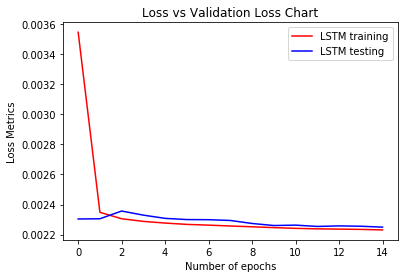

In [13]:
# Plotting/saving the graph on the loss and validation loss of the model throughout the training process
pyplot.plot(model_.history['loss'], label='LSTM training', color='red')
pyplot.plot(model_.history['val_loss'], label='LSTM testing', color= 'blue')
pyplot.xlabel('Number of epochs')
pyplot.ylabel('Loss Metrics')
pyplot.title('Loss vs Validation Loss Chart')
pyplot.legend()
pyplot.savefig(fname='Graph/loss chart.png', dpi = 350)
pyplot.show()